# Double Jet

With various grid sizes

In [1]:
from gpuocean.SWEsimulators import ModelErrorKL, CDKLM16
from gpuocean.utils import Common, IPythonMagic

from importlib import reload

import numpy as np
import pycuda.driver as cuda
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"


In [2]:
%cuda_context_handler gpu_ctx

In [3]:
gpu_stream = cuda.Stream()

In [4]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *

Get initial arguments from class

In [5]:
from gpuocean.utils import DoubleJetCase

SL-Ensemble of DoubleJets

In [6]:
doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=512, nx=1024)
doubleJetCase_args, doubleJetCase_init = doubleJetCase.getInitConditions()

In [7]:
args = {key: doubleJetCase_args[key] for key in ('nx', 'ny', 'dx', 'dy', 'gpu_ctx', 'boundary_conditions')}
args["gpu_stream"] = gpu_stream

In [8]:
data_args = {"eta" : doubleJetCase_init["eta0"],
             "hu" : doubleJetCase_init["hu0"],
             "hv" : doubleJetCase_init["hv0"],
             "Hi" : doubleJetCase_args["H"]}

In [9]:
sample_args = {"f": doubleJetCase_args["f"], "g": doubleJetCase_args["g"]}

In [10]:
sim_model_error_basis_args = {
                            "basis_x_start": 2, 
                            "basis_x_end": 8,
                            "basis_y_start": 1,
                            "basis_y_end": 7,

                            "kl_decay": 1.25,
                            "kl_scaling": 0.025,
                            }

sim_model_error_time_step = 60.0                        

In [13]:
from utils.DoubleJetSL import * 
SL_ensemble = initSLensemble(100, args, data_args, sample_args, 
                    init_model_error_basis_args=None, 
                    sim_model_error_basis_args=sim_model_error_basis_args, sim_model_error_time_step=sim_model_error_time_step)

In [14]:
SLstepToObservation(SL_ensemble, 6*60*60)

In [15]:
from utils.DoubleJetPlot import *

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

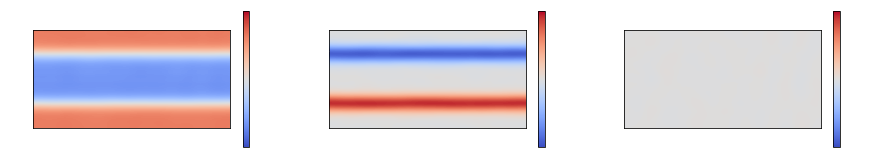

In [16]:
imshow3(SLestimate(SL_ensemble, np.mean), eta_vlim=3.5, huv_vlim=750)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

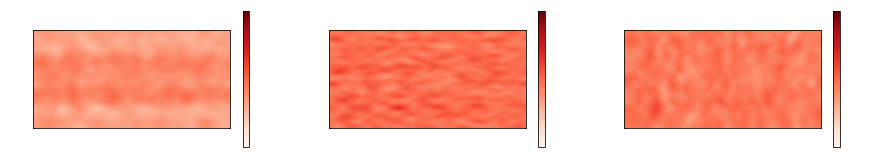

In [17]:
imshow3var(SLestimate(SL_ensemble, np.std), eta_vlim=0.5, huv_vlim=100)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

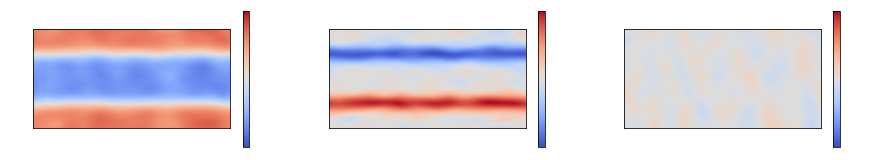

In [18]:
imshowSim(SL_ensemble[0], eta_vlim=3.5, huv_vlim=750)

Two-level ensemble

In [19]:
coarse_doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=256, nx=512)
coarse_doubleJetCase_args, coarse_doubleJetCase_init = coarse_doubleJetCase.getInitConditions()

In [20]:
coarse_args = {key: coarse_doubleJetCase_args[key] for key in ('nx', 'ny', 'dx', 'dy', 'gpu_ctx', 'boundary_conditions')}
coarse_args["gpu_stream"] = gpu_stream

In [21]:
coarse_data_args = {"eta" : coarse_doubleJetCase_init["eta0"],
             "hu" : coarse_doubleJetCase_init["hu0"],
             "hv" : coarse_doubleJetCase_init["hv0"],
             "Hi" : coarse_doubleJetCase_args["H"]}

In [22]:
ML_Nes = [100, 50]
args_list = [coarse_args, args]
data_args_list = [coarse_data_args, data_args]

In [23]:
sim_mekls = []
for l_idx in range(len(args_list)): 
    sim_mekls.append( ModelErrorKL.ModelErrorKL(**args_list[l_idx], **sim_model_error_basis_args) )

In [24]:
## MultiLevel ensemble
ML_ensemble = []

# 0-level
lvl_ensemble = []
for i in range(ML_Nes[0]):
    if i % 100 == 0: print(i)
    sim = make_sim(args_list[0], sample_args, init_fields=data_args_list[0])

    sim.model_error = sim_mekls[0]
    sim.model_time_step = sim_model_error_time_step
    lvl_ensemble.append( sim )

ML_ensemble.append(lvl_ensemble)

# diff-levels
for l_idx in range(1,len(ML_Nes)):
    print(l_idx)
    lvl_ensemble0 = []
    lvl_ensemble1 = []
    
    for e in range(ML_Nes[l_idx]):
        sim0 = make_sim(args_list[l_idx], sample_args, init_fields=data_args_list[l_idx])
        sim1 = make_sim(args_list[l_idx-1], sample_args, init_fields=data_args_list[l_idx-1])

        sim0.model_error = sim_mekls[l_idx]
        sim1.model_error = sim_mekls[l_idx-1]

        sim0.model_time_step = sim_model_error_time_step
        sim1.model_time_step = sim_model_error_time_step

        lvl_ensemble0.append(sim0)
        lvl_ensemble1.append(sim1)
    
    ML_ensemble.append([lvl_ensemble0,lvl_ensemble1])

0
1


In [25]:
from gpuocean.ensembles import MultiLevelOceanEnsemble
MLOceanEnsemble = MultiLevelOceanEnsemble.MultiLevelOceanEnsemble(ML_ensemble)

In [26]:
MLOceanEnsemble.stepToObservation(6*60*60)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

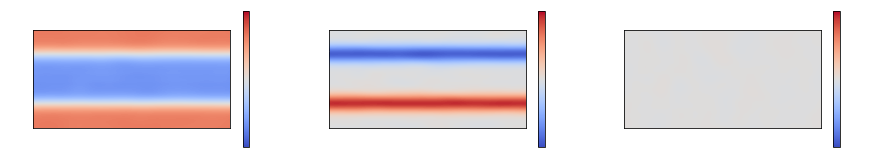

In [27]:
imshow3(MLOceanEnsemble.estimate(np.mean), eta_vlim=3.5, huv_vlim=750)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

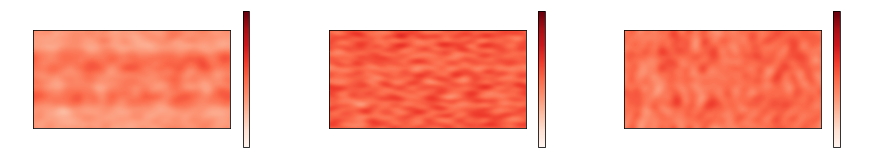

In [28]:
imshow3var(MLOceanEnsemble.estimate(np.std), eta_vlim=0.5, huv_vlim=100)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

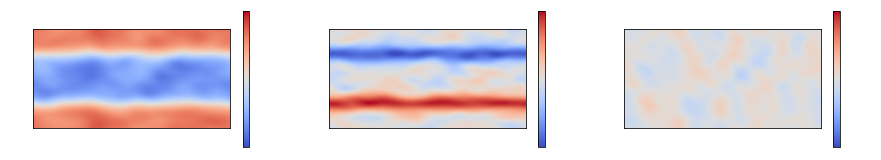

In [29]:
imshowSim(MLOceanEnsemble.ML_ensemble[1][0][1], eta_vlim=3.5, huv_vlim=750)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

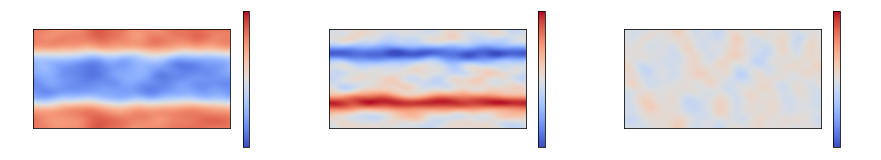

In [30]:
imshowSim(MLOceanEnsemble.ML_ensemble[1][1][1], eta_vlim=3.5, huv_vlim=750)